In [1]:
%cd ..

/mnt/d/Coding/segmentation


In [2]:
from model import AttentionUNet
from utils import *

In [3]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [4]:
import torch
model = AttentionUNet()
model.load_state_dict(torch.load("checkpoints/trained_model.pth"))
model.to(device)
model.eval()

AttentionUNet(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)

In [5]:
import pandas as pd


gt_df = pd.read_csv("data/kaggle/subset_gt.csv")
val_df = gt_df[gt_df["group"] == "kidney_3_dense"]

In [6]:
image_ids = val_df["id"].values
image_files = list(range(len(val_df)))

In [7]:
val_df[["height", "width"]]

,height,width
2279,1706,1510
2280,1706,1510
2281,1706,1510
2282,1706,1510
2283,1706,1510
...,...,...
2775,1706,1510
2776,1706,1510
2777,1706,1510
2778,1706,1510


In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import cv2
from data import H5ImageProcess, subset_preprocess_mask


h5_image_process = H5ImageProcess("data/kaggle/kidney_3_dense.hdf5")



class TestDataset(Dataset):
    def __init__(self, image_ids, image_files):
        self.image_ids = image_ids
        self.image_files = image_files
        self.resize_fn = Resize((256, 256), interpolation=cv2.INTER_NEAREST)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_file = self.image_files[idx]
        image = h5_image_process.preprocess_image_val(image_file)
        h, w = 1706, 1510
        image = self.resize_fn(image)
        return image_id, image, h, w

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [9]:
test_dataset = TestDataset(image_ids=image_ids, image_files=image_files)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [10]:
for image_id, image, hs, ws in test_dataloader:
    break

In [11]:
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle=='':
        rle = '1 0'
    return rle


def remove_small_objects(mask, min_size):
    # find all connected components (labels)
    num_label, label, stats, centroid = cv2.connectedComponentsWithStats(mask, connectivity=8)
    # create a mask where small objects are removed
    processed = np.zeros_like(mask)
    for l in range(1, num_label):
        if stats[l, cv2.CC_STAT_AREA] >= min_size:
            processed[label == l] = 1
    return processed

In [12]:
import torch
import torch.nn as nn
import numpy as np


image_ids = []
rles = []

for image_id, image, hs, ws in test_dataloader:
    image_ids.extend(image_id)
    with torch.no_grad():
        image = image.to(device)
        preds = model(image)
        preds = (nn.Sigmoid()(preds)>0.5).double()
    for pred, h, w in zip(preds.data.cpu(), hs, ws):
        reverse_resize = Resize((h, w), interpolation=cv2.INTER_NEAREST)
        pred = reverse_resize(pred)
        clean_pred = remove_small_objects(pred.numpy().squeeze().astype(np.uint8), 10)
        rles.append(rle_encode(clean_pred))

submision_df = pd.DataFrame({"id": image_ids, "rle": rles})

In [13]:
from dataclasses import dataclass, field, asdict
from typing import List

@dataclass
class Groundtruth:
    id: List[str] = field(default_factory=list)
    rle: List[str] = field(default_factory=list)
    group: List[str] = field(default_factory=list)
    slice: List[int] = field(default_factory=list)
    height: List[int] = field(default_factory=list)
    width: List[int] = field(default_factory=list)
    
    def convert(self, tensor):
        return [int(i) for i in tensor]
    
    def update(self, ids, rles, groups, slices, heights, widths):
        self.id.extend(ids)
        self.rle.extend(rles)
        self.group.extend(groups)
        self.slice.extend(self.convert(slices))
        self.height.extend(self.convert(heights))
        self.width.extend(self.convert(widths))
        
        
@dataclass
class Submission:
    id: List[str] = field(default_factory=list)
    rle: List[str] = field(default_factory=list)
    
    def convert(self, tensor):
        return [int(i) for i in tensor]
    
    def update(self, ids, rles):
        self.id.extend(ids)
        self.rle.extend(rles)

In [14]:
resize_fn = Resize((256, 256), interpolation=cv2.INTER_NEAREST)


def subset_preprocess_mask(lre, H=1303, W=912):
    mask = rle_decode(lre, (H, W))
    mask_tensor = torch.Tensor(mask)
    return mask_tensor


class ValDataset(Dataset):
    def __init__(self, df):
        self.image_paths = list(range(len(df)))
        self.label_paths = df["rle"].values
        self.group_names = df["group"].values
        self.slide_ids = df["slice"].values
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.label_paths[idx]
        group_name = self.group_names[idx]
        slice_id = self.slide_ids[idx]
        sample_id = f"{group_name}_{slice_id}"
        
        image = h5_image_process.preprocess_image_val(image_path)
        height, width = image.shape[1], image.shape[2]
        
        mask = subset_preprocess_mask(mask_path, 1706, 1510)
        image = resize_fn(image)
        return sample_id, image, mask, group_name, slice_id, height, width


val_dataset = ValDataset(val_df)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [15]:
from tqdm import tqdm
gt_dicts = Groundtruth()
sub_dicts = Submission()
# submission_dicts = []
for batch in tqdm(val_dataloader):
    sample_id, image, mask, group_name, slide_id, height, width = batch
    with torch.no_grad():
        image = image.to(device)
        preds = model(image)
        preds = (nn.Sigmoid()(preds)>0.5).double()
    
    rles = []
    for pred, h, w in zip(preds.data.cpu(), height, width):
        reverse_resize = Resize((1706, 1510), interpolation=cv2.INTER_NEAREST)
        pred = reverse_resize(pred)
        clean_pred = remove_small_objects(pred.numpy().squeeze().astype(np.uint8), 10)
        rles.append(rle_encode(clean_pred))
    gt_rles = []
    for m in mask:
        gt_rles.append(rle_encode(m.numpy().astype("uint8")))
    
    height = [1706] * len(height)
    width = [1510] * len(width)
    gt_dicts.update(sample_id, gt_rles, group_name, slide_id, height, width)
    sub_dicts.update(sample_id, rles)


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


In [16]:
gt_df = pd.DataFrame(asdict(gt_dicts))
sub_df = pd.DataFrame(asdict(sub_dicts))
gt_df = gt_df.sort_values(by="slice")

In [17]:
sub_df[sub_df["id"]=="kidney_3_dense_100"]["rle"].values[0]

'384167 6 385677 6 387187 6 388697 6 390207 6 391717 6 393168 17 393221 18 394678 17 394731 18 396188 17 396241 18 397698 17 397751 18 399208 17 399261 18 400718 17 400771 18 402228 17 402281 18 403726 29 403797 6 405236 29 405307 6 406746 29 406817 6 408256 29 408327 6 409766 29 409837 6 411276 29 411347 6 412786 29 412857 6 414284 36 415794 36 417304 36 418814 36 420324 36 421834 36 423338 42 423598 6 424848 42 425108 6 426358 42 426618 6 427868 42 428128 6 429378 42 429638 6 430888 42 431148 6 432398 42 432658 6 433896 48 435406 48 436916 48 438426 48 439936 48 441446 48 442956 48 444466 42 445976 42 447486 42 448996 42 450506 42 452016 42 453532 30 455042 30 456552 30 458062 30 459572 30 461082 30 462592 30 464203 11 465713 11 467223 11 468733 11 470243 11 471753 11 473263 11 474767 17 476277 17 477787 17 479297 17 480807 17 482317 17 483833 11 485343 11 486853 11 488363 11 489873 11 491383 11 492893 11 494403 11 495913 11 497423 11 498933 11 500443 11 501953 11 503463 11 504967 17

In [18]:
gt_df_real = pd.read_csv("/mnt/c/Users/binhn/Downloads/gt_df.csv")


In [19]:
from PIL import Image

sub_image = Image.fromarray(rle_decode(sub_df[sub_df["id"]=="kidney_3_dense_100"]["rle"].values[0], shape=(1706,1510))*255)
gt_image = Image.fromarray(rle_decode(gt_df.iloc[100]["rle"], shape=(1706,1510))*255)

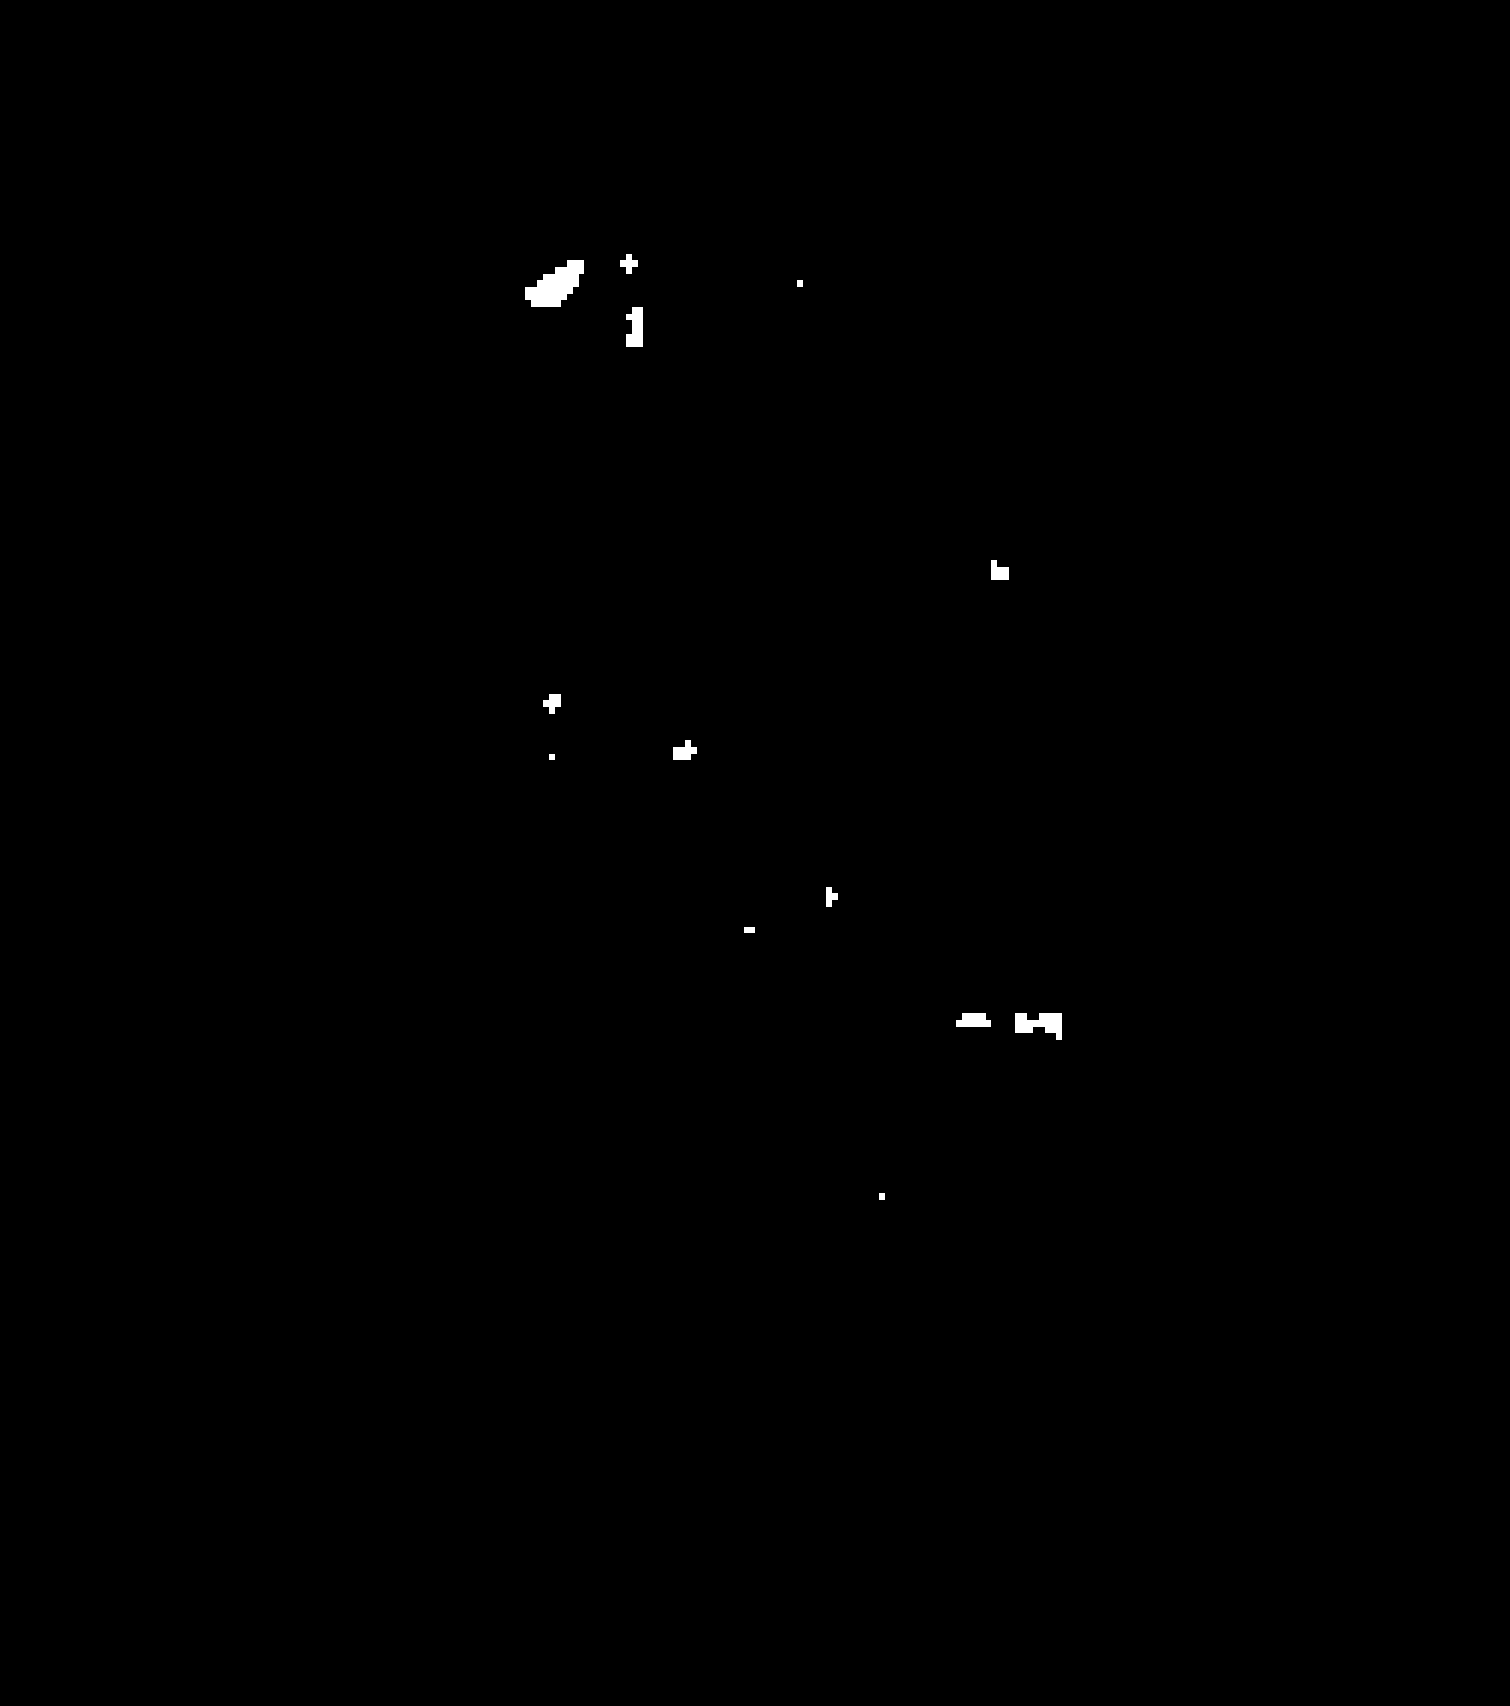

In [20]:
sub_image

In [21]:
# gt_df["rle"] = gt_df_real["rle"]

In [3]:
gt_df = pd.read_csv("data/gt_df.csv")
sub_df = pd.read_csv("data/sub_df.csv")
score(sub_df, gt_df, "id", "rle", image_id_column_name="group", slice_id_column_name="slice")

0.15139620006084442

In [26]:
gt_df.to_csv("data/gt_df.csv", index=False)
sub_df.to_csv("data/sub_df.csv", index=False)